In [507]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import scipy.stats as stats

In [508]:
# Write a function to extract particular variables and years of Scripps pier data from the downloaded files

def get_Scripps_pier_data(variables, years=np.arange(2005, 2022, 1)):

    # Open the first data file, and concatenate each file onto it to get one data array
    data_all = xr.open_dataset('scripps_pier-2005.nc')
    for i in range(6,22):
        if i < 10:
            data_int = xr.open_dataset('scripps_pier-200'+str(i)+'.nc')
        else:
            data_int = xr.open_dataset('scripps_pier-20'+str(i)+'.nc')

        data_all = xr.concat([data_all, data_int], dim='time')
    
    # Chnage the time to the correct format for xarray
    time = [np.datetime64(ti) for ti in data_all.time.data]
    data_all['time'] = time
    
    # Select the years desired
    data_all_years = data_all.sel(time=data_all.time.dt.year.isin(years))
    
    # Select the variables desired
    data = data_all_years[variables]
    
    return data


In [509]:
# Get the temperature and pressure data for 2015 and 2021
data = get_Scripps_pier_data(['temperature', 'pressure'], years=[2015, 2021])

In [510]:
# Define each dataset separately for ease later
temp_data_15 = data['temperature'].sel(time=data.time.dt.year == 2015)
temp_data_21 = data['temperature'].sel(time=data.time.dt.year == 2021)

pres_data_15 = data['pressure'].sel(time=data.time.dt.year == 2015)
pres_data_21 = data['pressure'].sel(time=data.time.dt.year == 2021)

# 1) Visual Evaluation

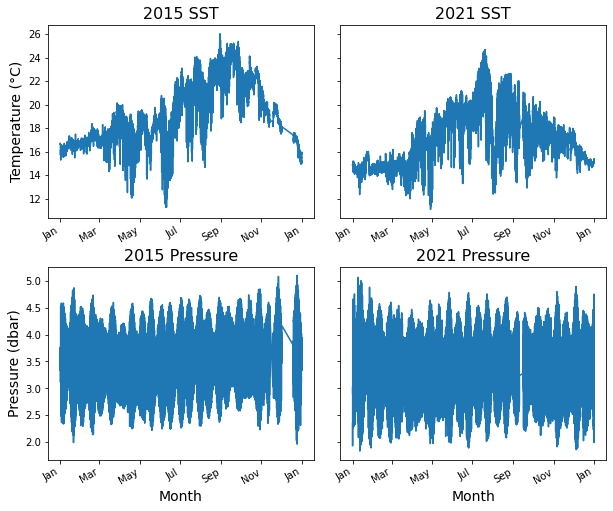

<function matplotlib.pyplot.close(fig=None)>

In [511]:
# Plot the temperature and pressure for both years
fig = plt.figure(figsize=(10,8))
gs = fig.add_gridspec(2, 2, hspace=0.25, wspace=0.1)
(ax1, ax2), (ax3, ax4) = gs.subplots(sharey='row')

temp_data_15.plot(ax=ax1)
temp_data_21.plot(ax=ax2)
pres_data_15.plot(ax=ax3)
pres_data_21.plot(ax=ax4)

ax3.set_xlabel('Month', fontsize=14)
ax4.set_xlabel('Month', fontsize=14)
ax1.set_ylabel('Temperature (°C)', fontsize=14)
ax3.set_ylabel('Pressure (dbar)', fontsize=14)

ax1.set_xlabel('')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax4.set_ylabel('')

ax1.set_title('2015 SST', fontsize=16)
ax2.set_title('2021 SST', fontsize=16)
ax3.set_title('2015 Pressure', fontsize=16)
ax4.set_title('2021 Pressure', fontsize=16)

locator = mdates.MonthLocator()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.show()
plt.close

The two years chosen are 2015 (strong El Nino year) and 2021 (La Nina year). The most obviuous difference is that 2015 was noticable warmer than 2021. The seasonal cycle is observed clearly in both years but temperature spikes occur at different times of year. From simply looking at the timeseries, not much difference can be seen in the pressure data. There is a bigger gap in data in 2015 around Nov-Dec.

# 2) Means

In [512]:
# Find the standard error in the mean for each variable and each year
error_temp_15 = np.std(temp_data_15.data)/np.sqrt(sum(~np.isnan(temp_data_15.data)))
error_temp_21 = np.std(temp_data_21.data)/np.sqrt(sum(~np.isnan(temp_data_21.data)))

error_pres_15 = np.std(pres_data_15.data)/np.sqrt(sum(~np.isnan(pres_data_15.data)))
error_pres_21 = np.std(pres_data_21.data)/np.sqrt(sum(~np.isnan(pres_data_21.data)))

print('The mean SST in 2015 is:', round(np.nanmean(temp_data_15.data),3), '±', round(error_temp_15, 4), '°C')
print('The mean SST in 2021 is:', round(np.nanmean(temp_data_21.data),3), '±', round(error_temp_21, 4), '°C')

print('The mean pressure in 2015 is:', round(np.nanmean(pres_data_15.data),3), '±', round(error_pres_15, 4), 'dbar')
print('The mean pressure in 2021 is:', round(np.nanmean(pres_data_21.data),3), '±', round(error_pres_21, 4), 'dbar')

The mean SST in 2015 is: 19.254 ± 0.0091 °C
The mean SST in 2021 is: 17.274 ± 0.0067 °C
The mean pressure in 2015 is: 3.501 ± 0.0017 dbar
The mean pressure in 2021 is: 3.356 ± 0.0014 dbar


In [513]:
# Sample each dataset once per day (just after midnight each time)
temp_data_15_samp = temp_data_15.sortby('time').resample(time='1D').first()
temp_data_21_samp = temp_data_21.sortby('time').resample(time='1D').first()
pres_data_15_samp = pres_data_15.sortby('time').resample(time='1D').first()
pres_data_21_samp = pres_data_21.sortby('time').resample(time='1D').first()

# Recalculate the standard error for the once-per-day sampled data
error_temp_15_samp = np.nanstd(temp_data_15_samp.data)/np.sqrt(sum(~np.isnan(temp_data_15_samp.data)))
error_temp_21_samp = np.nanstd(temp_data_21_samp.data)/np.sqrt(sum(~np.isnan(temp_data_21_samp.data)))

error_pres_15_samp = np.nanstd(pres_data_15_samp.data)/np.sqrt(sum(~np.isnan(pres_data_15_samp.data)))
error_pres_21_samp = np.nanstd(pres_data_21_samp.data)/np.sqrt(sum(~np.isnan(pres_data_21_samp.data)))

print('The mean SST in 2015 (if sampled once per day) is:', round(np.nanmean(temp_data_15_samp.data),2), '±', round(error_temp_15_samp, 2), '°C')
print('The mean SST in 2021 (if sampled once per day) is:', round(np.nanmean(temp_data_21_samp.data),2), '±', round(error_temp_21_samp, 2), '°C')

print('The mean pressure in 2015 (if sampled once per day) is:', round(np.nanmean(pres_data_15_samp.data),2), '±', round(error_pres_15_samp, 3), 'dbar')
print('The mean pressure in 2021 (if sampled once per day) is:', round(np.nanmean(pres_data_21_samp.data),2), '±', round(error_pres_21_samp, 3), 'dbar')

The mean SST in 2015 (if sampled once per day) is: 19.57 ± 0.14 °C
The mean SST in 2021 (if sampled once per day) is: 17.79 ± 0.13 °C
The mean pressure in 2015 (if sampled once per day) is: 3.36 ± 0.026 dbar
The mean pressure in 2021 (if sampled once per day) is: 3.19 ± 0.026 dbar


2021 and 2015 are very different years (due to ENSO) so unsurprisingly, the mean temperatures are not consistent within the error bars. The pressure is also different between the years, although less so, but the means are still not consistent within the error bars.

If you resample the data only once per day, the standard error increases substantially. However, in for both the temperature and pressure, the subsampled means are still not consistent between the two years. Interestingly, the temperature increases and the pressure decreases when the data is subsampled, suggesting that it is warming and the pressure is lower around midnight.

# 3) Variance

In [514]:
# Calculate the standard error in variance in the temperature and pressure data for each year
error_var_temp_15 = np.std(temp_data_15.data)**2*np.sqrt(2/(sum(~np.isnan(temp_data_15.data))-1))
error_var_temp_21 = np.std(temp_data_21.data)**2*np.sqrt(2/(sum(~np.isnan(temp_data_21.data))-1))

error_var_pres_15 = np.std(pres_data_15.data)**2*np.sqrt(2/(sum(~np.isnan(pres_data_15.data))-1))
error_var_pres_21 = np.std(pres_data_21.data)**2*np.sqrt(2/(sum(~np.isnan(pres_data_21.data))-1))

print('The variance in SST in 2015 is:', round(np.nanstd(temp_data_15.data)**2,2), '±', round(error_var_temp_15, 3), '°C²')
print('The variance in SST in 2021 is:', round(np.nanstd(temp_data_21.data)**2,2), '±', round(error_var_temp_21, 3), '°C²')

print('The variance in pressure in 2015 is:', round(np.nanstd(pres_data_15.data)**2,3), '±', round(error_var_pres_15, 4), 'dbar²')
print('The variance in pressure in 2021 is:', round(np.nanstd(pres_data_21.data)**2,3), '±', round(error_var_pres_21, 4), 'dbar²')

The variance in SST in 2015 is: 6.81 ± 0.034 °C²
The variance in SST in 2021 is: 5.88 ± 0.023 °C²
The variance in pressure in 2015 is: 0.243 ± 0.0012 dbar²
The variance in pressure in 2021 is: 0.258 ± 0.001 dbar²


In [515]:
# Repeat but for the resampled data
error_var_temp_15_samp = np.nanstd(temp_data_15_samp.data)**2*np.sqrt(2/(sum(~np.isnan(temp_data_15_samp.data))-1))
error_var_temp_21_samp = np.nanstd(temp_data_21_samp.data)**2*np.sqrt(2/(sum(~np.isnan(temp_data_21_samp.data))-1))

error_var_pres_15_samp = np.nanstd(pres_data_15_samp.data)**2*np.sqrt(2/(sum(~np.isnan(pres_data_15_samp.data))-1))
error_var_pres_21_samp = np.nanstd(pres_data_21_samp.data)**2*np.sqrt(2/(sum(~np.isnan(pres_data_21_samp.data))-1))

print('The variance in SST in 2015 (if sampled once per day) is:', round(np.nanstd(temp_data_15_samp.data)**2,1), '±', round(error_var_temp_15_samp, 2), '°C²')
print('The variance in SST in 2021 (if sampled once per day) is:', round(np.nanstd(temp_data_21_samp.data)**2,1), '±', round(error_var_temp_21_samp, 2), '°C²')

print('The variance in pressure in 2015 (if sampled once per day) is:', round(np.nanstd(pres_data_15_samp.data)**2,2), '±', round(error_var_pres_15_samp, 3), 'dbar²')
print('The variance in pressure in 2021 (if sampled once per day) is:', round(np.nanstd(pres_data_21_samp.data)**2,2), '±', round(error_var_pres_21_samp, 3), 'dbar²')

The variance in SST in 2015 (if sampled once per day) is: 7.1 ± 0.54 °C²
The variance in SST in 2021 (if sampled once per day) is: 6.0 ± 0.45 °C²
The variance in pressure in 2015 (if sampled once per day) is: 0.23 ± 0.018 dbar²
The variance in pressure in 2021 (if sampled once per day) is: 0.25 ± 0.019 dbar²


As before, there is a substantial difference between the variance in both temperature and pressure between the two years such that they are not consistent within the error bars between the two years. Variance in temperature is higher and variance in pressure is lower in 2015 than 2021.

If you subsample the data once per day (around midnight), the standard error in the variance increases significantly. The error bars for the variance in pressure now overlap, but the variance values for temperature are still not consistent between the years.

# 4) Extreme values

In [516]:
# Calculate the extreme values that are three sigma above the mean
extreme_val_temp_15 = np.mean(temp_data_15.data) + 3*np.std(temp_data_15.data)
extreme_val_temp_21 = np.mean(temp_data_21.data) + 3*np.std(temp_data_21.data)

extreme_val_pres_15 = np.mean(pres_data_15.data) + 3*np.std(pres_data_15.data)
extreme_val_pres_21 = np.mean(pres_data_21.data) + 3*np.std(pres_data_21.data)

# Find the PDF for the data and calculate the probability of exceeding the extreme value
kde_temp_15 = stats.gaussian_kde(temp_data_15.data)
prob_exceedance_temp_15 = kde_temp_15.integrate_box_1d(extreme_val_temp_15, 100)
print('The probability of exceeding 3σ greater than the 2015 temperature mean is {0:.7f}'.format(prob_exceedance_temp_15*100), '%')

# Find the probability of exceeding the extreme value for a normal distirbution
prob_exceedance_temp_15_norm = 1-stats.norm(np.mean(temp_data_15.data),np.std(temp_data_15.data)).cdf(extreme_val_temp_15)
print('Assuming a normal distribution, the probability of exceeding 3σ greater than the 2015 temperature mean is {0:.2f}'.format(prob_exceedance_temp_15_norm*100), '%\n')

kde_temp_21 = stats.gaussian_kde(temp_data_21.data)
prob_exceedance_temp_21 = kde_temp_21.integrate_box_1d(extreme_val_temp_21, 100)
print('The probability of exceeding 3σ greater than the 2021 temperature mean is {0:.3f}'.format(prob_exceedance_temp_21*100), '%')

prob_exceedance_temp_21_norm = 1-stats.norm(np.mean(temp_data_21.data),np.std(temp_data_21.data)).cdf(extreme_val_temp_21)
print('Assuming a normal distribution, the probability of exceeding 3σ greater than the 2021 temperature mean is {0:.2f}'.format(prob_exceedance_temp_21_norm*100), '%\n')

kde_pres_15 = stats.gaussian_kde(pres_data_15.data)
prob_exceedance_pres_15 = kde_pres_15.integrate_box_1d(extreme_val_pres_15, 100)
print('The probability of exceeding 3σ greater than the 2015 pressure mean is {0:.4f}'.format(prob_exceedance_pres_15*100), '%')

prob_exceedance_pres_15_norm = 1-stats.norm(np.mean(pres_data_15.data),np.std(pres_data_15.data)).cdf(extreme_val_pres_15)
print('Assuming a normal distribution, the probability of exceeding 3σ greater than the 2015 pressure mean is {0:.2f}'.format(prob_exceedance_pres_15_norm*100), '%\n')

kde_pres_21 = stats.gaussian_kde(pres_data_21.data)
prob_exceedance_pres_21 = kde_pres_21.integrate_box_1d(extreme_val_pres_21, 100)
print('The probability of exceeding 3σ greater than the 2021 pressure mean is {0:.3f}'.format(prob_exceedance_pres_21*100), '%')

prob_exceedance_pres_21_norm = 1-stats.norm(np.mean(pres_data_21.data),np.std(pres_data_21.data)).cdf(extreme_val_pres_21)
print('Assuming a normal distribution, the probability of exceeding 3σ greater than the 2021 pressure mean is {0:.2f}'.format(prob_exceedance_pres_21_norm*100), '%\n')


The probability of exceeding 3σ greater than the 2015 temperature mean is 0.0000001 %
Assuming a normal distribution, the probability of exceeding 3σ greater than the 2015 temperature mean is 0.13 %

The probability of exceeding 3σ greater than the 2021 temperature mean is 0.026 %
Assuming a normal distribution, the probability of exceeding 3σ greater than the 2021 temperature mean is 0.13 %

The probability of exceeding 3σ greater than the 2015 pressure mean is 0.0059 %
Assuming a normal distribution, the probability of exceeding 3σ greater than the 2015 pressure mean is 0.13 %

The probability of exceeding 3σ greater than the 2021 pressure mean is 0.013 %
Assuming a normal distribution, the probability of exceeding 3σ greater than the 2021 pressure mean is 0.13 %



As expected, the probability of exceeding three standard deviations above the mean for a Gaussian distribtuion is always the same, 0.13%. The probability of exceeding this threshold is much lower for the given distributions I am looking at, particularly the 2015 temperature distribution.

# 5) Probability density functions

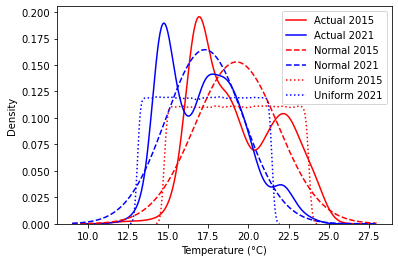

<function matplotlib.pyplot.close(fig=None)>

In [517]:
x_vals = np.arange(9,28, 0.01)

# Find the lower and upper limits of the uniform distribution from the known mean and standard deviation
a_temp_15 = np.mean(temp_data_15.data) - np.sqrt(12)/2*np.std(temp_data_15.data)
b_temp_15 = np.mean(temp_data_15.data) + np.sqrt(12)/2*np.std(temp_data_15.data)
a_temp_21 = np.mean(temp_data_21.data) - np.sqrt(12)/2*np.std(temp_data_21.data)
b_temp_21 = np.mean(temp_data_21.data) + np.sqrt(12)/2*np.std(temp_data_21.data)

# Plot the actual, normal and uniform distributions for temperature for both years on the same plot
sns.kdeplot(temp_data_15.data, c='r', bw_adjust=2, label='Actual 2015')
sns.kdeplot(temp_data_21.data, c='b', bw_adjust=2, label='Actual 2021')
plt.plot(x_vals, stats.norm.pdf(x_vals, np.mean(temp_data_15.data), np.std(temp_data_15.data)), c='r', ls='--', label='Normal 2015')
plt.plot(x_vals, stats.norm.pdf(x_vals, np.mean(temp_data_21.data), np.std(temp_data_21.data)), c='b', ls='--', label='Normal 2021')
sns.kdeplot(np.random.uniform(a_temp_15, b_temp_15, 1000000), c='r', ls=':', label='Uniform 2015')
sns.kdeplot(np.random.uniform(a_temp_21, b_temp_21, 1000000), c='b', ls=':', label='Uniform 2021')
plt.xlabel('Temperature (°C)')
plt.legend()
plt.show()
plt.close

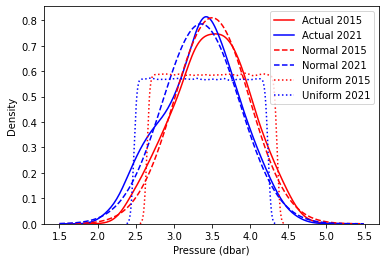

<function matplotlib.pyplot.close(fig=None)>

In [518]:
x_vals = np.arange(1.5,5.5, 0.01)

# Find the lower and upper limits of the uniform distribution from the known mean and standard deviation
a_pres_15 = np.mean(pres_data_15.data) - np.sqrt(12)/2*np.std(pres_data_15.data)
b_pres_15 = np.mean(pres_data_15.data) + np.sqrt(12)/2*np.std(pres_data_15.data)
a_pres_21 = np.mean(pres_data_21.data) - np.sqrt(12)/2*np.std(pres_data_21.data)
b_pres_21 = np.mean(pres_data_21.data) + np.sqrt(12)/2*np.std(pres_data_21.data)

# Plot the actual, normal and uniform distributions for pressure for both years on the same plot
sns.kdeplot(pres_data_15.data, c='r', bw_adjust=2, label='Actual 2015')
sns.kdeplot(pres_data_21.data, c='b', bw_adjust=2, label='Actual 2021')
plt.plot(x_vals, stats.norm.pdf(x_vals, np.mean(pres_data_15.data), np.std(pres_data_15.data)), c='r', ls='--', label='Normal 2015')
plt.plot(x_vals, stats.norm.pdf(x_vals, np.mean(pres_data_21.data), np.std(pres_data_21.data)), c='b', ls='--', label='Normal 2021')
sns.kdeplot(np.random.uniform(a_pres_15, b_pres_15, 1000000), c='r', ls=':', label='Uniform 2015')
sns.kdeplot(np.random.uniform(a_pres_21, b_pres_21, 1000000), c='b', ls=':', label='Uniform 2021')
plt.xlabel('Pressure (dbar)')
plt.legend()
plt.show()
plt.close

The temperature distributions are not well approximated by Gaussians, whereas the pressure distributions are a lot closer to Gaussian. A uniform distribution does not fit either well at all. 

I collaborated with Jack Bauchop on this assignment.